In [ ]:
!unzip -q data.zip -d data

replace data/test/dog0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace data/test/dog1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/test/dog2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## 1.  Open Set Recognition on MNSIT
To start experimenting with Open Set Recognition (OSR) we use as usual MNIST and a Resnet-18 model, which allow us to train easily and visualize the results in short time.

We will start training a model on a subset of MNIST, then we will evaluate this model, applying OSR techniques to detect if a character is from the original set or is from a different set


As usual, first some inclueds

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import os


We make sure we are running wiht a GPU

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cpu


We use Resnet-18, so, no need to manually write the model, we can import it from the pytorch library

In [ ]:
import torchvision.models as models

We now redifine Resnet-18, in particular we change the last layer to match the numer of classes of our custom dataset, 5 classes of MNIST as the know classes in the dataset

In [ ]:
class ResNetOSR(nn.Module):
    def __init__(self, num_classes=5):  # 5 Known classes
        super(ResNetOSR, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)

We then define the classes we are going to consider as known (0,1,4,7,9)

In [ ]:
# **Define Known Classes**
known_classes = {0, 1, 4, 7, 9}

Since we are using a Resnet-18 some transformation on the data are required. In particular, if we don't want to edit too much the model, we have to adapt the data.
Due to the number of layers and consequent data size reduction we have to increase the size of the input up to 64x64
Resnet is also designed for RGB images, while MNIST is greyscale, so we expand the channel up to 3

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Increase size to 64x64
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert 1-channel to 3-channel
    transforms.Normalize((0.5,), (0.5,))
])

We now get our train and val dataset

In [ ]:
mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_val = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.21MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.87MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We now have to define the subset dataset we will train the model on. In particular, we want to learn to detect only the five classes previously defined.

For this we create a custom function to process the dataset, filter_dataset

In [ ]:
def filter_dataset(dataset, class_set):
    indices = [i for i, (_, label) in enumerate(dataset) if label in class_set]
    return Subset(dataset, indices)

Our new train dataset is then created usingthis function

In [ ]:
train_known = filter_dataset(mnist_train, known_classes)
val_known = filter_dataset(mnist_val, known_classes)

Next we create a simple dataloader with only these data, and a batch size of 64

In [ ]:
# **Create DataLoaders**
batch_size = 64
train_loader = DataLoader(train_known, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_known, batch_size=batch_size, shuffle=False)

Finally we define the model, our slightly modified Resnet-18, a loss function, for this simple classification task we use cross entropy, and the optimizer, we use Adam for this.

In [ ]:
# **Initialize Model, Loss, Optimizer**
model = ResNetOSR(num_classes=len(known_classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


We also set the patience of the early stopping and a counter utility variable

In [ ]:
# **Early Stopping Parameters**
patience = 5  # Stop training if no improvement in 'patience' epochs
best_val_loss = float("inf")
early_stop_counter = 0

We set the number of epochs we want to train our model, and set the model in training mode

In [ ]:
# **Train Model**
epochs = 10
model.train()

ResNetOSR(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Now we start the training phasetrain our model

we itarate through the multiple epochs
we iterate through the images in the dataloader


This line of code is used to remap the labels, since we are using only 5 labels, which are not consecutive, we have to match the training labels (0-4) with the 5 values associated to the images in the original dataset
```
labels = torch.tensor([sorted(known_classes).index(label.item()) for label in labels]).to(device)
```

Next we compute the output of the model given one image,  compute the loss and perform backpropagation. We also compute the training loss

The next step is to validate the model to perform early stopping when needed.
We set the model in eval mode and proceed with validation iterating through all validation set images. Also for the validation we compute the loss.

Finally we check how the validation loss is changing, if the value is lower than the previous lowest value we save the weights. If it is higher we increment the early stop counter and if we reach the counter we stop the training proces





In [ ]:
# MAIN CODE TO TRAIN (MAYBE DON'T RUN IT)

for epoch in range(epochs):
    total_loss = 0
    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels to match known class indices
        labels = torch.tensor([sorted(known_classes).index(label.item()) for label in labels]).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # **Validation Phase**
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor([sorted(known_classes).index(label.item()) for label in labels]).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # **Early Stopping Check**
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter since we improved
        # Save the best model
        os.makedirs("output_osr_mnist", exist_ok=True)
        model_path = "output_osr_mnist/best_model.pth"
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved with Val Loss: {avg_val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter}/{patience} epochs.")

    # Stop training if no improvement for `patience` epochs
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print(f"Training completed. Best model saved at: {model_path}")

Now we have a model trained to perform classification on five MNIST class.
We can now test it on the whole MNIST dataset and see if we can detect if an image is from our original dataset or if it is from ouside.

We rewrite our include. Probably not needed, but better be sure

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import torchvision.models as models
import torch.nn as nn

Also the GPU should still be there

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cpu


We now define our dataset, this time it will have all classes from MNIST, part of them as known and part as unkown.

In [ ]:
# **Load MNIST Dataset**
def load_datasets():
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert 1-channel to 3-channel
        transforms.Normalize((0.5,), (0.5,))
    ])

    mnist_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

    known_classes = {0, 1, 4, 7, 9}
    unknown_classes = {2, 3, 5, 8}

    def filter_dataset(dataset, class_set):
        indices = [i for i, (_, label) in enumerate(dataset) if label in class_set]
        return Subset(dataset, indices)

    test_known = filter_dataset(mnist_test, known_classes)
    test_unknown = filter_dataset(mnist_test, unknown_classes)

    print(f"Dataset sizes: Known: {len(test_known)}, Unknown: {len(test_unknown)}")
    return test_known, test_unknown

Now we have to define the metrics used to discriminate between know and unkown samples. We star with entropy, computed on the probability distribution of the different classes, which is the output of the softmax function. The logits are weighted using the temperature value before using them in the softmax to accentuate differences

In [ ]:
# **Compute Entropy**
def compute_entropy(outputs, temperature=5.0):
    scaled_outputs = outputs / temperature
    probabilities = F.softmax(scaled_outputs, dim=1)
    entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)
    return entropy.detach().cpu().numpy()

Now we define the max logit function, which simply take the max value of the output logits

In [ ]:
# **Compute Max-Logit**
def compute_max_logit(outputs):
    max_logit = torch.max(outputs, dim=1)[0]
    return max_logit.detach().cpu().numpy()

We also use an improved version of simply taking the max logit value. We compute the energy of the logits, which is the log of the sum of the exponential of the logits

In [ ]:
# **Compute Energy Score**
def compute_energy_score(outputs, temperature=1.0):
    energy = -temperature * torch.logsumexp(outputs / temperature, dim=1)
    return energy.detach().cpu().numpy()

We now define our evaluate function.

The function takes different arguments, like the method used for the evaluation, entropy or max logit, and the threshold used to discriminate between knwon and unkown

We set the model in eval mode and begin iteration thorugh the images for both sents, the known and unkown. We save the predictions and apply the entropy or max logit to the scores

From the vector of predicted groups (known/uknown) we can then compute the auroc value, which is the area under the ROC curve, the True Positive Rate (TPR) vs False Positive Rate (FPR) at different thresholds, and the accuracy.

Finally for visualization purpose and also to allow tuining of the threshold we plot an histogram showing the number of elements for different values of entropy or max logit

In [ ]:
# **Evaluate and Plot OSR (Entropy or Max-Logit)**
def evaluate_osr(model, test_known_loader, test_unknown_loader, threshold, output_folder, temperature, method="entropy"):
    model.eval()
    known_scores, unknown_scores = [], []

    with torch.no_grad():
        for images, _ in test_known_loader:
            images = images.to(device)
            outputs = model(images)
            if method == "entropy":
                known_scores.extend(compute_entropy(outputs, temperature=temperature))
            elif method == "maxlogit":
                known_scores.extend(compute_max_logit(outputs))
            elif method == "energy":
                known_scores.extend(compute_energy_score(outputs, temperature=temperature))

        for images, _ in test_unknown_loader:
            images = images.to(device)
            outputs = model(images)
            if method == "entropy":
                unknown_scores.extend(compute_entropy(outputs, temperature=temperature))
            elif method == "maxlogit":
                unknown_scores.extend(compute_max_logit(outputs))
            elif method == "energy":
                unknown_scores.extend(compute_energy_score(outputs, temperature=temperature))

    y_true = np.array([1] * len(known_scores) + [0] * len(unknown_scores))
    y_scores = np.array(known_scores + unknown_scores)

    auroc = roc_auc_score(y_true, -y_scores if method in ["entropy", "energy"] else y_scores)
    preds = (y_scores < threshold if method in ["entropy", "energy"] else y_scores > threshold).astype(int)
    acc = np.mean(preds == y_true)

    print(f"{method.capitalize()} OSR: AUROC: {auroc:.4f}, Accuracy: {acc:.4f}")

    # **Plot Distribution**
    plt.figure(figsize=(8, 5))
    plt.hist(known_scores, bins=30, alpha=0.5, label='Known', color='blue')
    plt.hist(unknown_scores, bins=30, alpha=0.5, label='Unknown', color='red')
    plt.axvline(threshold, color='black', linestyle='dashed', label='Threshold')
    plt.xlabel(f"{method.capitalize()} Score")
    plt.ylabel("Frequency")
    plt.title(f"{method.capitalize()} Distribution")
    plt.legend()
    os.makedirs(output_folder, exist_ok=True)
    plt.savefig(f"{output_folder}/{method}_distribution.png")
    plt.show()

Similarly we want to visualize the predictions. Taking some random samples and showing if the model is really able to discriminate between known and unkown.

The function has a similar structure to the previous one. In this scenario we only take the first 10 images from the dataset, perform prediction and compute the scors, with entropy or max logit. Finally we print into a single image the images with the gt and predicted value.

In [ ]:
def visualize_predictions(model, test_known_loader, test_unknown_loader, threshold, output_folder, temperature, method="entropy"):
    model.eval()
    fig, axes = plt.subplots(4, 5, figsize=(10, 8))
    axes = axes.ravel()

    samples = []
    true_classes = []

    with torch.no_grad():
        for images, _ in test_known_loader:
            samples.extend(images[:10])
            true_classes.extend(["Known"] * len(images[:10]))
            break

        for images, _ in test_unknown_loader:
            samples.extend(images[:10])
            true_classes.extend(["Unknown"] * len(images[:10]))
            break

    samples = torch.stack(samples).to(device)
    outputs = model(samples)

    if method == "entropy":
        scores = compute_entropy(outputs, temperature=temperature)
    elif method == "maxlogit":
        scores = compute_max_logit(outputs)
    elif method == "energy":
        scores = compute_energy_score(outputs, temperature=temperature)  # Fix: Pass temperature
    else:
        raise ValueError("Invalid method. Choose 'entropy', 'maxlogit', or 'energy'.")

    for i, (ax, img, score, true_label) in enumerate(zip(axes, samples, scores, true_classes)):
        if method in ["entropy", "energy"]:
            prediction = "Known" if score < threshold else "Unknown"
        else:  # maxlogit
            prediction = "Known" if score > threshold else "Unknown"

        img = img.cpu().squeeze().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img, cmap="gray")
        ax.set_title(f"Pred: {prediction}\nTrue: {true_label}", fontsize=8,
                     color="green" if prediction == true_label else "red")
        ax.axis("off")

    # Hide unused axes if we have less than 20 samples
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    os.makedirs(output_folder, exist_ok=True)
    plt.savefig(f"{output_folder}/osr_visualization_{method}.png")
    plt.show()

Now we run our main function, we set some parameters, create the model and the dataloaders.

In [ ]:
model_path="data/best_model_osr.pth"
entropy_threshold=1.0
mlg_threshold=6.0
output_folder="output_osr_mnist"
temperature=5.0
energy_threshold=-9.2


os.makedirs(output_folder, exist_ok=True)

model = ResNetOSR(num_classes=5).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Loaded model from {model_path}")

test_known, test_unknown = load_datasets()
test_known_loader = DataLoader(test_known, batch_size=64, shuffle=False)
test_unknown_loader = DataLoader(test_unknown, batch_size=64, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-37-b7b563800c11>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

Loaded model from data/best_model_osr.pth
Dataset sizes: Known: 5134, Unknown: 3908


Finally we can run the two evaluations. We start with the max logit

Maxlogit OSR: AUROC: 0.9751, Accuracy: 0.9100


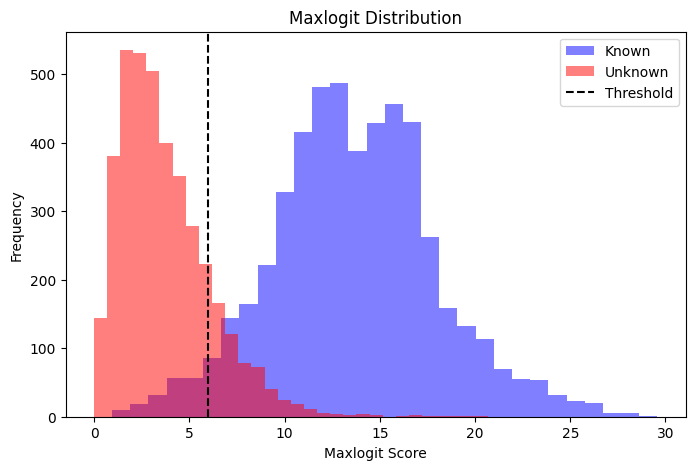

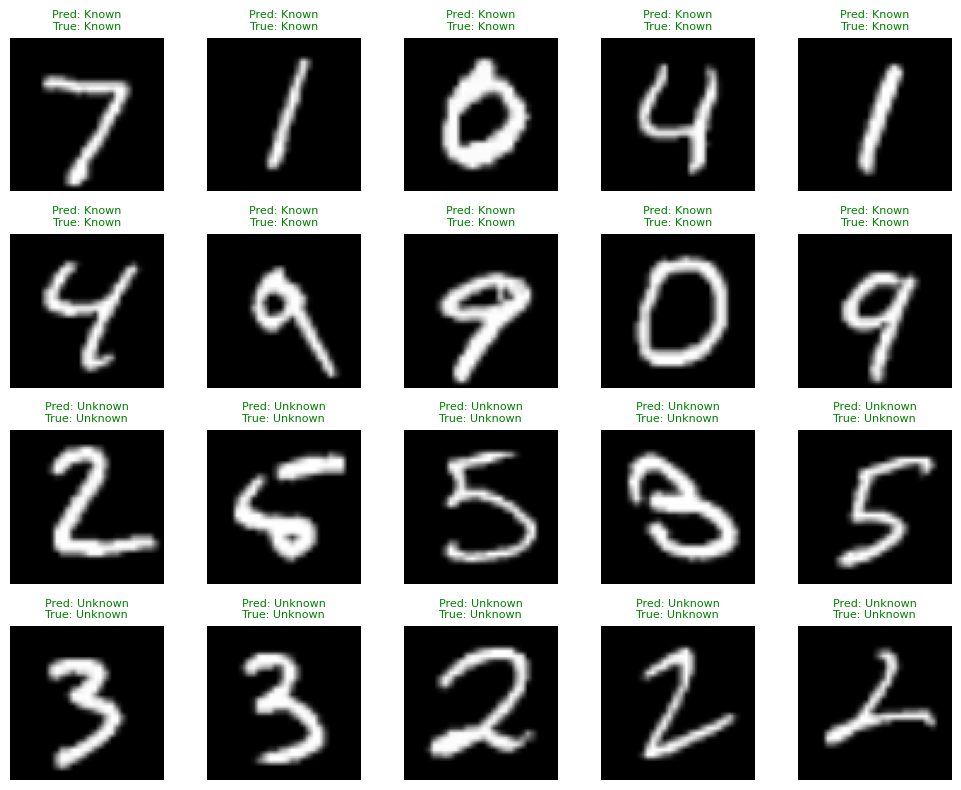

In [ ]:
evaluate_osr(model, test_known_loader, test_unknown_loader, mlg_threshold, output_folder, temperature, method="maxlogit")
visualize_predictions(model, test_known_loader, test_unknown_loader, mlg_threshold, output_folder, temperature, method="maxlogit")

Now with the energy

Energy OSR: AUROC: 0.9721, Accuracy: 0.9209


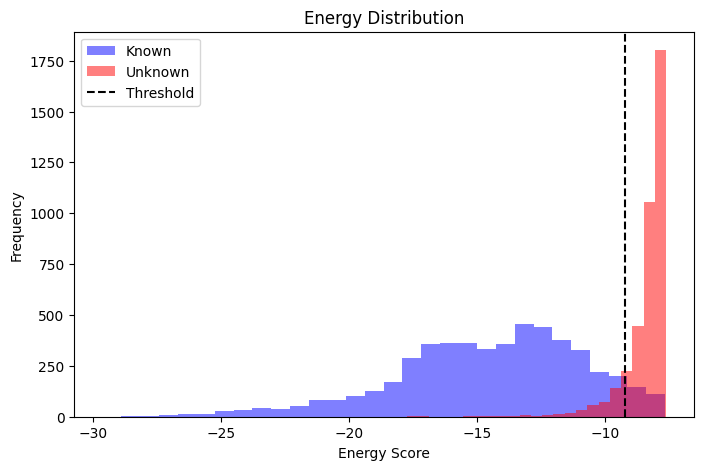

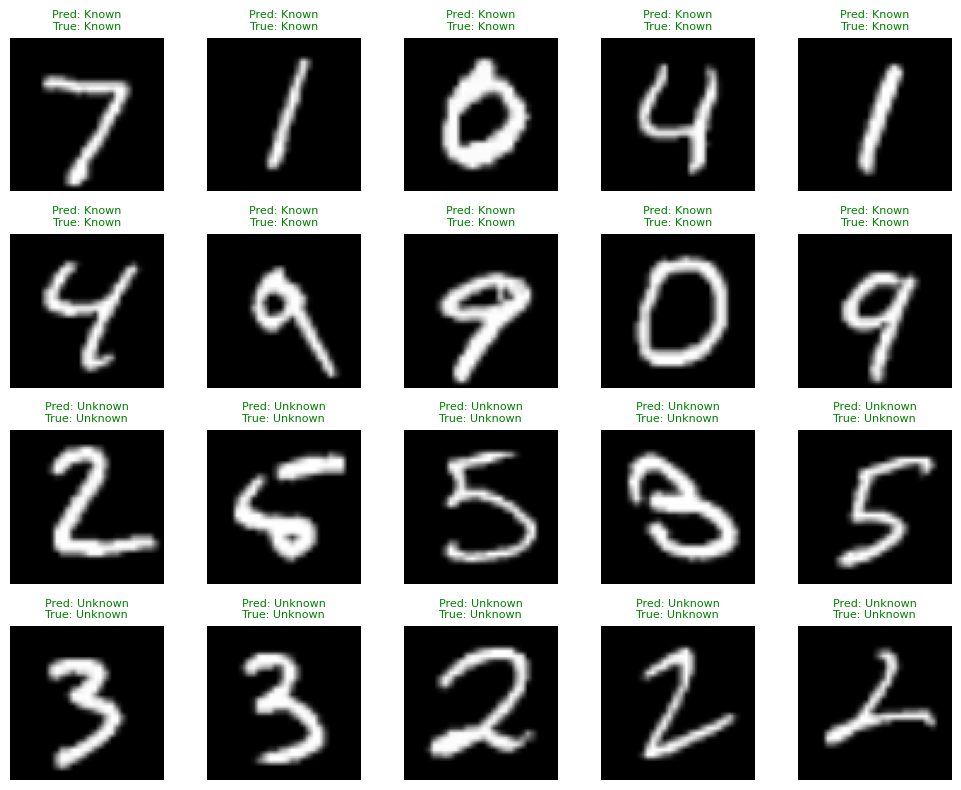

In [ ]:
evaluate_osr(model, test_known_loader, test_unknown_loader, energy_threshold, output_folder, temperature, method="energy")
visualize_predictions(model, test_known_loader, test_unknown_loader, energy_threshold, output_folder, temperature, method="energy")

Next with the entropy

Entropy OSR: AUROC: 0.9774, Accuracy: 0.9249


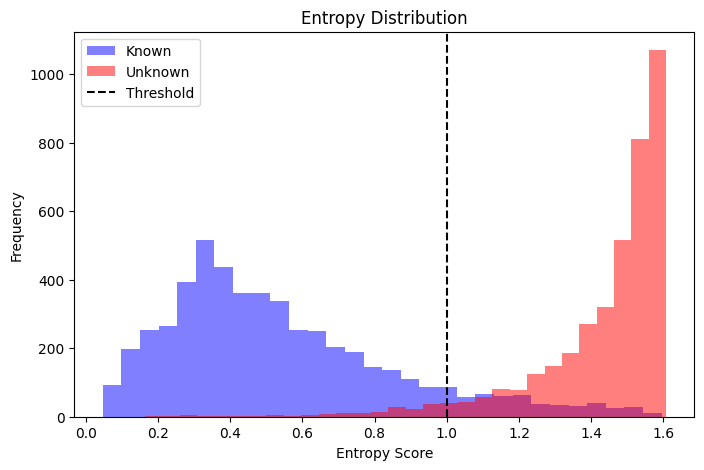

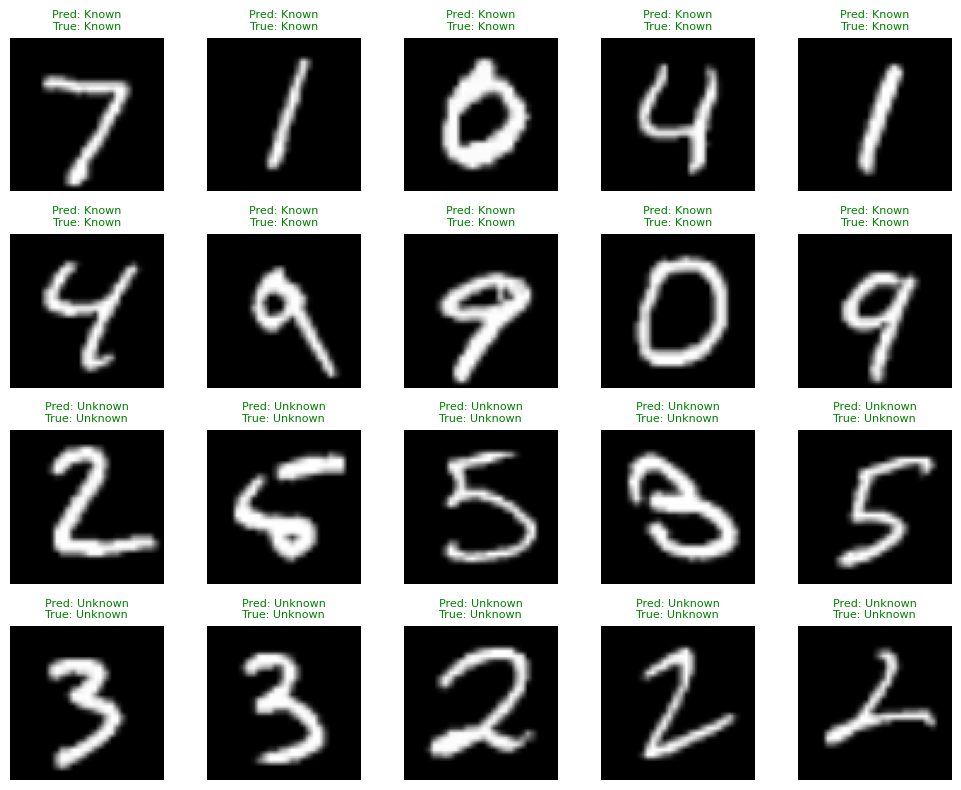

In [ ]:
evaluate_osr(model, test_known_loader, test_unknown_loader, entropy_threshold, output_folder, temperature, method="entropy")
visualize_predictions(model, test_known_loader, test_unknown_loader, entropy_threshold, output_folder, temperature, method="entropy")

## 2. Teacher Student
We now move to the student teacher approach. In particular, we use as teacher a big network, Resnet-50, and try to train a smaller network, a custom one with just a few layers, on the cifar-10 dataset.

Since we don't have any pretrained model on cifar-10 we have to fine tune a preexisting one on this new dataset. The first part of this notebook is then a simple training of Resnet-50 on cifar-10.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import os

We define our dataset

In [ ]:
# Load CIFAR-10 Dataset
def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader


And our model, with 10 classes output

In [ ]:
# Define Teacher Model
def get_teacher_model():
    teacher = models.resnet50(pretrained=True)
    teacher.fc = nn.Linear(2048, 10)  # Adjust for CIFAR-10
    return teacher.cuda()

Train the big teacher model

In [ ]:
# Training Function with Early Stopping and Checkpointing
def train_teacher(model, trainloader, testloader, epochs=20, model_name="teacher.pth", patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    best_loss = float("inf")
    patience_counter = 0
    model_path = f"./{model_name}"

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)  # Save best model weights
            print(f"Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

In [ ]:
# Evaluate Function
def evaluate_teacher(model, testloader, model_name):
    model.load_state_dict(torch.load(model_name))  # Load best model weights
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
# Main Execution (DON'T RUN ON COLAB)
trainloader, testloader = get_data_loaders()
teacher = get_teacher_model()

print("\nTraining Teacher Model on CIFAR-10")
train_teacher(teacher, trainloader, testloader, epochs=200, model_name="teacher.pth")

print("\nEvaluating Teacher Model")
teacher_acc = evaluate_teacher(teacher, testloader, "teacher.pth")
print(f"Teacher Model Accuracy on CIFAR-10: {teacher_acc:.2f}%")

Now we should have a teacher model, a Resnet-50 trained on cifar-10. The weight shoudl be saved as teacher.pth

We can now move on and start training our student model. In particular, we will train both a standard version of the network, without exploiting the teacher information, and one with distillation, lavaraging the pre-trained Resnet-50

Again some standard import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import os


We create our Dataloader for Cifar, in this case we don't require particular data transformation

In [ ]:
# Load CIFAR-10 Dataset
def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

And we define our student CNN. A considerably smaller model than our teacher Resnet-50; just a few layers of convolutions.

In [ ]:
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Next we take our teacher model, we load the custom weight trained previously and we adapt as in the training phase the last layer to match the correct number of outputs

In [ ]:
# Load Trained Teacher Model
def get_teacher_model(model_path="data/teacher.pth"):
    teacher = models.resnet50(pretrained=False)  # Do not use pretrained weights, load trained model
    teacher.fc = nn.Linear(2048, 10)  # Adjust for CIFAR-10
    teacher.load_state_dict(torch.load(model_path))  # Load trained weights
    return teacher.cuda().eval()

Here we have the core components of our training process. The distillation loss

The loss has two components:
-  a soft component which compares the outputs between teacher and student
- an hard component, the standard loss against the ground truth on the classificaiton task

The function takes then as input not the prediction, but the logits from both teacher and student

we first compute the soft loss, we divide the logits by the temperature to soften them. Next we compute the softmax for the teacher and the log softmax for the student, due to the KL Divergence Loss. We then compute the KLDivLoss, which compare the probability distribution of the student against the teacher. We mulyiply the result to T*T to solve a scaling issue due to the initial division for T, since we have to then combine this loss with the hard loss

The second step si to compute the hard loss. This is a standard classification loss and we use corss entropy.

Now that we have two losses we have to combine them. We use an alpha factor of 0.7 in this example to combine the two loss values.



In [ ]:
# Define Distillation Loss
def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    soft_targets = nn.KLDivLoss(reduction="batchmean")(
        nn.functional.log_softmax(student_logits / T, dim=1),
        nn.functional.softmax(teacher_logits / T, dim=1)
    ) * (T * T)
    hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
    return alpha * soft_targets + (1 - alpha) * hard_loss

Now we write the train function

We iterate through epocsh, then thorugh images. The function is designed to train both the student and the standard model so in the loop we check if we are training with distillation. If this is the case we run the teacher to get the logits, then we run the student, and call the distillation loss to compute the loss against the teacher. Instead if we are training the standard model we simply use the passed criterion, which is a crossentropy loss. Given the loss we proceed with backpropagation, check if the loss has decreased and save the model.

In [ ]:
# Training Function with Early Stopping and Checkpointing
def train(model, trainloader, criterion, optimizer, teacher=None, use_distillation=False, epochs=10, model_name="model.pth", patience=3):
    best_loss = float("inf")
    patience_counter = 0
    model_path = f"./{model_name}"

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            if use_distillation:
                with torch.no_grad():
                    teacher_logits = teacher(images)
                student_logits = model(images)
                loss = distillation_loss(student_logits, teacher_logits, labels)
            else:
                loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)  # Save best model weights
            print(f"Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break


We now write a simple evaluate function that we will use to compare the different models

In [ ]:
# Evaluate Function
def evaluate(model, testloader, model_name=None):
    if model_name:  # Only load weights if a model file is provided
        model.load_state_dict(torch.load(model_name))
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Now we can start the train process, first we define the data loaders and our teacher model

In [ ]:
# Main Execution
trainloader, testloader = get_data_loaders()
teacher = get_teacher_model("data/teacher.pth")  # Load the fine-tuned teacher model

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-37-696869523f0d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

Then  we start the training of the standard model, without distillation

In [ ]:
# Train Student Without Distillation
print("\nTraining Student Model (No Distillation)")
student_no_distill = StudentCNN().cuda()
optimizer = optim.Adam(student_no_distill.parameters(), lr=0.001)



Training Student Model (No Distillation)


In [ ]:
# Start the training process (NOT ON COLAB)
train(student_no_distill, trainloader, nn.CrossEntropyLoss(), optimizer, epochs=120, model_name="student_no_distill.pth")

Next we train the student model

In [ ]:
# Train Student With Distillation
print("\nTraining Student Model (With Distillation)")
student_distilled = StudentCNN().cuda()
optimizer = optim.Adam(student_distilled.parameters(), lr=0.001)



Training Student Model (With Distillation)


In [ ]:
# Start the training process (NOT ON COLAB)
train(student_distilled, trainloader, nn.CrossEntropyLoss(), optimizer, teacher, use_distillation=True, epochs=120, model_name="student_distilled.pth")

And finally we evaluate, the teacher, the student and the version wihtout distillation

In [ ]:
# Evaluate All Models
print("\nEvaluating Models...")
print(f"Teacher Accuracy: {evaluate(teacher, testloader, None):.2f}%")
print(f"Student (No Distillation) Accuracy: {evaluate(student_no_distill, testloader, 'data/student_no_distill.pth'):.2f}%")
print(f"Student (With Distillation) Accuracy: {evaluate(student_distilled, testloader, 'data/student_distilled.pth'):.2f}%")


Evaluating Models...
Teacher Accuracy: 85.46%


<ipython-input-40-255f5cf45d78>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


Student (No Distillation) Accuracy: 74.20%
Student (With Distillation) Accuracy: 76.56%


## 3. Deep Anomaly Detection Using Geometric Transformations

Here we imlpement the paper "Deep Anomaly Detection Using Geometric Transformations". The paper lavarage a big Wide Residual Network (WRN), trained for 200 epochs. Threfore training directly on colab requires long time, we provided some pre-trained weights.

As usual some standard includes

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps

Then, the paper define 72 transformations that are applied to the image. As from the paper the transformations are from 3 groups:
- Horizontal flip
- Translation
- Rotation of multiple of 90 degrees

Combining all possible values of these (2x3x3x4) we get 72 possible values

In particular our code fist define the combination of the transformations using four nested loops (two are required for the shig). We proceed from flip (true/false), vertical shift (up/none/down), horizontal shifft (left/none/right), and rotations (0/90/180/270). This gives us a vector which defines our transformation.

Then, given an image and a vector which defines our transformation we apply them to the input image and return the final transformed image.

In [ ]:
class GeometricTransformations:
    def __init__(self):
        self.transforms = []
        for flip in [False, True]:  # Horizontal flip
            for sh in [-1, 0, 1]:  # Vertical shift
                for sw in [-1, 0, 1]:  # Horizontal shift
                    for rot in [0, 90, 180, 270]:  # Rotation
                        self.transforms.append((flip, sh, sw, rot))

    def apply(self, img, transform_index):
        flip, sh, sw, rot = self.transforms[transform_index]
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)  # Convert Tensor to PIL Image

        # Apply transformations
        if flip:
            img = ImageOps.mirror(img)
        img = img.rotate(rot)
        img = img.transform(img.size, Image.AFFINE, (1, 0, sw * img.width * 0.25, 0, 1, sh * img.height * 0.25))
        return img

    def get_num_transforms(self):
        return len(self.transforms)

Next, we have to define our network, a Wide Residual Network. We have to first manually define the residual block as a series of convolutions, Batch normalization and relus

In [ ]:
# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Skip connection
        out = self.relu(out)
        return out


Now that we have defined the Residual Block we can proceed with the network definition. The network start with a convolution, followed by three residual blocks, and a final layer to map the number of classes.

The depth parameter regulate the number of residual block that are added by the _make_layer function.

The widen_factor instead regulates the number of channel in the network

In [ ]:
# Define the Wide Residual Network (WRN)
class WRN(nn.Module):
    def __init__(self, depth=16, widen_factor=8, num_classes=72):
        super(WRN, self).__init__()
        assert (depth - 4) % 6 == 0, "Depth should be 6n+4"
        n = (depth - 4) // 6
        channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]

        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(channels[0], channels[1], n, stride=1)
        self.layer2 = self._make_layer(channels[1], channels[2], n, stride=2)
        self.layer3 = self._make_layer(channels[2], channels[3], n, stride=2)

        self.bn2 = nn.BatchNorm2d(channels[3])
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

We now define an helper class to create our custom dataset, we take as input the original dataset, with his classes, like cat or dog, and given an image it ammpy a random transformation from the 72 possible transformations

In [ ]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, geo_transforms):
        self.base_dataset = base_dataset
        self.geo_transforms = geo_transforms

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]  # ignore the original label
        # Randomly select a transformation
        transform_idx = np.random.randint(0, self.geo_transforms.get_num_transforms())
        transformed_img = self.geo_transforms.apply(img, transform_idx)
        # Convert back to tensor (if needed)
        transformed_img = transforms.ToTensor()(transformed_img)
        return transformed_img, transform_idx

Now we have the main train function

We set some variables for early stopping

Then we iterate thorugh epochs and images

We monitor the loss each epoch and save models with lower loss

In [ ]:
# Training function with early stopping
def train(model, train_loader, criterion, optimizer, device, num_epochs=200, early_stopping_patience=20):
    best_loss = float('inf')
    patience_counter = 0
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    # Plot loss curve
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.savefig("training_loss.png")
    print("Training complete. Loss curve saved as training_loss.png")

Now that we have defined all the required functions we can start the training process

Check the GPU

In [ ]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
geo_transforms = GeometricTransformations()

We now create our dataset, we load the original one, and we convert it to our custom dataset.

In [ ]:
# Load dataset (HERE ON COLAB WE DON´T HAVE THE COMPLETE DATASET, IF NEEDED DOWNLOAD IT FROM KAGGLE)
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor()
])
base_dataset = datasets.ImageFolder(root='./data/catsvsdogs/train', transform=data_transform)
train_dataset = TransformedDataset(base_dataset, geo_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

We create the model, set the loss function, and the optimizer, following the setup of the original paper

In [ ]:
# Initialize model, loss, optimizer
model = WRN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

And we start the training

In [ ]:
# Train model (AS USUAL, NOT ON COLAB)
train(model, train_loader, criterion, optimizer, device)

Now that we have trained our model we can proceed with the validation

As usual some includes

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

We define the transformations, as done before

In [ ]:
class GeometricTransformations:
    def __init__(self):
        self.transforms = []
        for flip in [False, True]:
            for sh in [-1, 0, 1]:
                for sw in [-1, 0, 1]:
                    for rot in [0, 90, 180, 270]:
                        self.transforms.append((flip, sh, sw, rot))
    def apply(self, img, transform_index):
        flip, sh, sw, rot = self.transforms[transform_index]
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        if flip:
            img = ImageOps.mirror(img)
        img = img.rotate(rot)
        img = img.transform(img.size, Image.AFFINE, (1, 0, sw * img.width * 0.25, 0, 1, sh * img.height * 0.25))
        return img
    def get_num_transforms(self):
        return len(self.transforms)

And we define the residual block

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

And the WRN network

In [ ]:
class WRN(torch.nn.Module):
    def __init__(self, depth=16, widen_factor=8, num_classes=72):
        super(WRN, self).__init__()
        assert (depth - 4) % 6 == 0, "Depth should be 6n+4"
        n = (depth - 4) // 6
        channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        self.conv1 = torch.nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(channels[0])
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(channels[0], channels[1], n, stride=1)
        self.layer2 = self._make_layer(channels[1], channels[2], n, stride=2)
        self.layer3 = self._make_layer(channels[2], channels[3], n, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(channels[3])
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(channels[3], num_classes)
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return torch.nn.Sequential(*layers)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.relu(self.bn2(out))
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

Now we have to define a way to discriminate between normal and anomaly images.
The original work, given an image, computes all the transfomration of the image and predict the probability of each one of these image. The score is computed as the mean of the probability of the correct class. So, given the input this is the diagonal of the softnamx scores.

This is the simplified function shown in the paper. An alternative solution is to use the Dirichlet Normality Score

In [ ]:
def compute_normality_score(model, img, device, geo_transforms):
    transformed_imgs = []
    for i in range(geo_transforms.get_num_transforms()):
        t_img = geo_transforms.apply(img, i)
        t_img_tensor = transforms.ToTensor()(t_img)
        transformed_imgs.append(t_img_tensor)
    transformed_imgs = torch.stack(transformed_imgs).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(transformed_imgs)
        softmax_scores = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        # Compute the mean of the diagonal elements of the softmax matrix
        score = np.mean(np.diag(softmax_scores))
    return score

Now we check we have a gpu, initialize the transformations, the network and the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
geo_transforms = GeometricTransformations()

# Load the trained model (make sure best_model.pth exists and is compatible)
model = WRN(depth=16, widen_factor=8, num_classes=72).to(device)
model.load_state_dict(torch.load("data/best_model_anomaly.pth", map_location=device))
model.eval()

<ipython-input-81-42b1cbbd4c8e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("data/best_model_anomaly.pth", map_location=device))


WRN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

We set the theshold for the score to divide between normal and anomaly

In [ ]:
threshold = 0.45  # If score >= threshold, image is considered norma (dog), otherwise anomaly (cat)


We load our data and iterate through the images. For each one we compute the normality score

In [ ]:
# Path to the test folder (images named like "cat1.jpg", "dog2.png", etc.)
test_folder = "data/test"

# Get list of image files (assume extensions: .jpg, .png, .jpeg)
test_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

results = []  # To store info for each test image
for filename in test_files:
    filepath = os.path.join(test_folder, filename)
    img = Image.open(filepath).convert("RGB")
    score = compute_normality_score(model, img, device, geo_transforms)
    # Infer ground-truth from filename: if filename starts with "dog" => normal; "cat" => anomaly.
    if filename.lower().startswith("dog"):
        gt = "normal"
    elif filename.lower().startswith("cat"):
        gt = "anomaly"
    else:
        gt = "unknown"
    # Prediction: if score >= threshold, predict normal; otherwise anomaly.
    pred = "normal" if score >= threshold else "anomaly"
    results.append({"filename": filename, "img": img, "score": score, "gt": gt, "pred": pred})

Finally we plot an image with the predictions, the scores, and the gt

Final inference grid saved as final_inference_grid.png


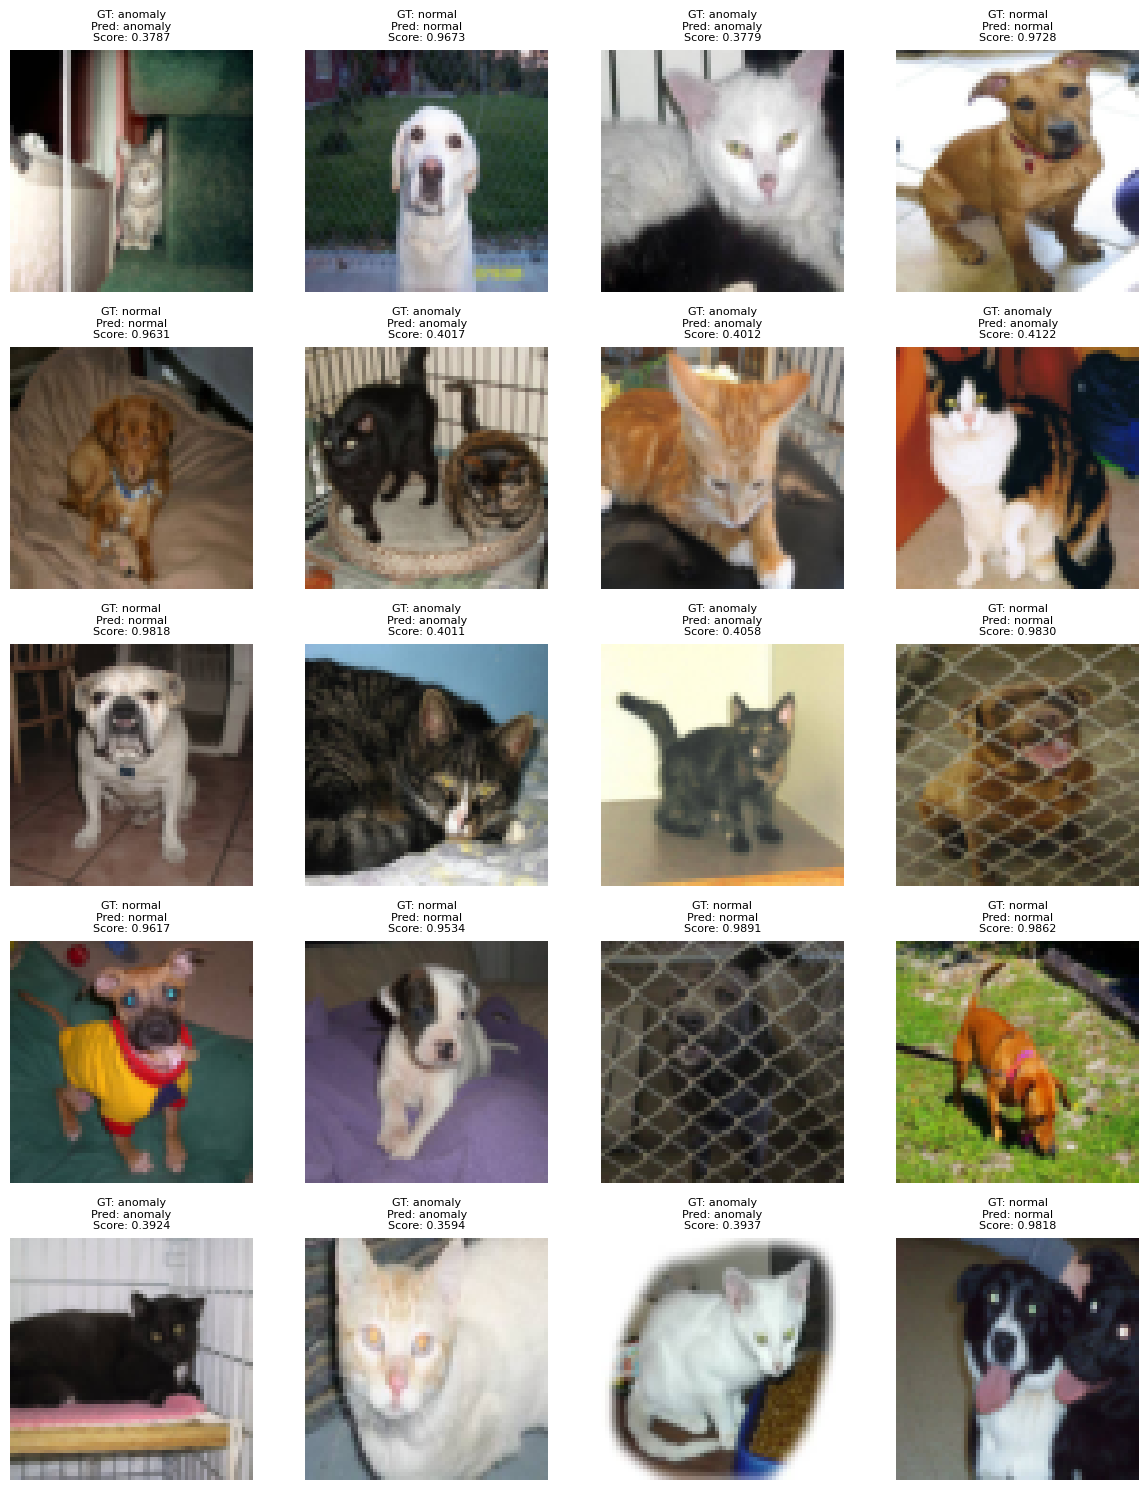

In [ ]:
num_images = len(results)
cols = 4
rows = (num_images + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()
for ax in axes:
    ax.axis("off")

for i, res in enumerate(results):
    ax = axes[i]
    ax.imshow(res["img"])
    title = f"GT: {res['gt']}\nPred: {res['pred']}\nScore: {res['score']:.4f}"
    ax.set_title(title, fontsize=8)
plt.tight_layout()
final_image_path = "final_inference_grid.png"
plt.savefig(final_image_path)
print(f"Final inference grid saved as {final_image_path}")
plt.show()